# VGG19를 이용한 Gram Matrix 기반 두 이미지 간의 스타일 차이 측정

In [1]:
import torch, torch.nn.functional as F
import torchvision.transforms as T
from torchvision.models import vgg19, VGG19_Weights
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

# 전처리 (VGG19 기준)
IMG_SIZE = 256
preprocess = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def load_image(path: str | Path):
    return Image.open(path).convert('RGB')

def to_tensor(pil_img):
    return preprocess(pil_img).unsqueeze(0).to(device)

def gram(x):
    b, c, h, w = x.size()
    y = x.view(b, c, h*w)
    return y @ y.transpose(1, 2) / (c*h*w)

class StyleEncoder(torch.nn.Module):
    """VGG19 conv1_1~conv5_1 feature 추출기"""
    def __init__(self, layers=("0","5","10","19","28")):
        super().__init__()
        vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features
        self.layers = set(layers)
        self.max_id = max(map(int, layers))
        self.net = torch.nn.Sequential(*(vgg[i] for i in range(self.max_id+1)))
        for p in self.net.parameters():
            p.requires_grad_(False)

    def forward(self, x):
        feats = []
        for idx, layer in enumerate(self.net):
            x = layer(x)
            if str(idx) in self.layers:
                feats.append(x)
        return feats

encoder = StyleEncoder().to(device).eval()

### 생성이미지 vs.  스타일 이미지

In [2]:
gen_img_path = "/home/elicer/GramMatrix/Image/VTON-gen-Img1.jpeg"
style_ref_path = "/home/elicer/GramMatrix/Image/VTON-style1.jpeg"

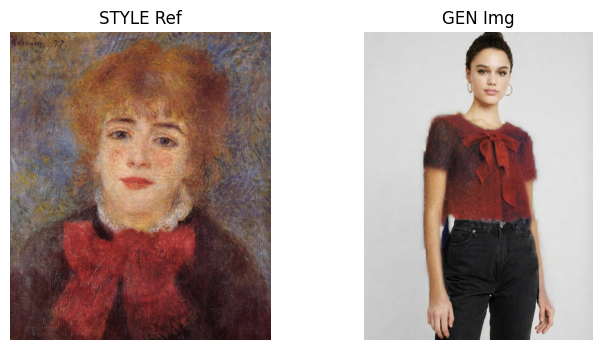

In [3]:
pil1, pil2 = load_image(style_ref_path), load_image(gen_img_path)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(pil1); axes[0].set_title("STYLE Ref"); axes[0].axis("off")
axes[1].imshow(pil2); axes[1].set_title("GEN Img"); axes[1].axis("off")
plt.show()

In [4]:
with torch.no_grad():
    t1, t2 = to_tensor(pil1), to_tensor(pil2)
    f1, f2 = encoder(t1), encoder(t2)
    style_dist = sum(F.mse_loss(gram(a), gram(b))
                     for a, b in zip(f1, f2)).item()

print(f"▶ Gram-based Style Distance : {style_dist:.4f}")

▶ Gram-based Style Distance : 0.0014


##  원래 이미지 vs. 생성 이미지
-> 여기를 원래 이미지 대신 다른 모델 이미지를 넣으시면 비교하기 좋을 것 같습니다.

In [5]:
style_ref_path = "/home/elicer/GramMatrix/Image/VTON-style2.jpeg"
original_path = "/home/elicer/GramMatrix/Image/VTON-origin2.png"
stylized_path = "/home/elicer/GramMatrix/Image/VTON-gen2.png"

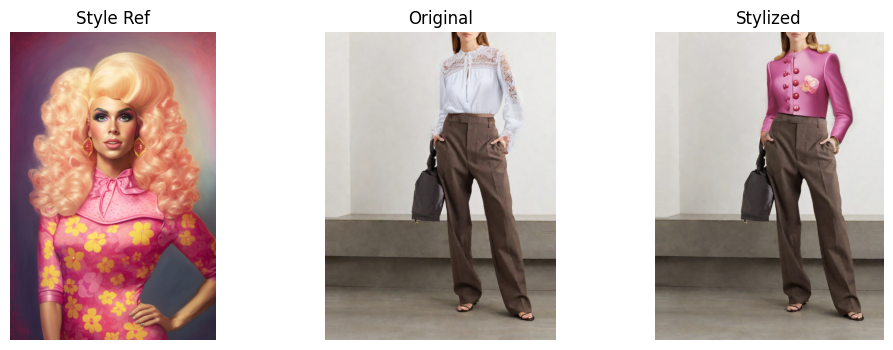

In [6]:
orig_pil = load_image(original_path)
styl_pil = load_image(stylized_path)
ref_pil  = load_image(style_ref_path)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(ref_pil);   axes[0].set_title("Style Ref"); axes[0].axis("off")
axes[1].imshow(orig_pil);  axes[1].set_title("Original"); axes[1].axis("off")
axes[2].imshow(styl_pil);  axes[2].set_title("Stylized"); axes[2].axis("off")

plt.show()

In [7]:
with torch.no_grad():
    t_orig = to_tensor(orig_pil)
    t_styl = to_tensor(styl_pil)
    t_ref  = to_tensor(ref_pil)

    f_orig = encoder(t_orig)
    f_styl = encoder(t_styl)
    f_ref  = encoder(t_ref)

    # 스타일 참조 vs 생성 이미지
    dist_styl_vs_ref = sum(F.mse_loss(gram(a), gram(b))
                           for a, b in zip(f_styl, f_ref)).item()

    # 원본 vs 생성 이미지
    dist_orig_vs_styl = sum(F.mse_loss(gram(a), gram(b))
                            for a, b in zip(f_orig, f_styl)).item()

print(f"▶ Stylized vs Style Ref:     {dist_styl_vs_ref:.4f}")
print(f"▶ Original vs Stylized:     {dist_orig_vs_styl:.4f}")

▶ Stylized vs Style Ref:     0.0012
▶ Original vs Stylized:     0.0002


In [8]:
with torch.no_grad():
    t_orig = to_tensor(orig_pil)
    t_styl = to_tensor(styl_pil)
    t_ref  = to_tensor(ref_pil)

    f_orig = encoder(t_orig)
    f_styl = encoder(t_styl)
    f_ref  = encoder(t_ref)

    # 스타일 참조 vs 생성 이미지
    dist_styl_vs_ref = sum(F.mse_loss(gram(a), gram(b)) for a, b in zip(f_styl, f_ref)).item()

    
    # 스타일 참조 vs 원본 이미지
    dist_orig_vs_ref = sum(F.mse_loss(gram(a), gram(b)) for a, b in zip(f_orig, f_ref)).item()

print(f"▶ Stylized vs StyleRef : {dist_styl_vs_ref:.4f}")
print(f"▶ Original vs StyleRef : {dist_orig_vs_ref:.4f}")

▶ Stylized vs StyleRef : 0.0012
▶ Original vs StyleRef : 0.0015
